<h1 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Alzheimer MR Images Classification</h1>

<div style="color: black; background-color: lightsteelblue; border:2px solid black;">
    <ul>
        <p>Project ini menggunakan lebih dari 12.000 citra MRI (Magnetic Resonance Image) berbeda yang dikelompokkan ke dalam 4 kelas berbeda. Kelas-kelas tersebut adalah sebagai berikut;</p>
            <li>Non Demented</li>
            <li>Very Mild Demented</li>
            <li>Mild Demented</li>
            <li>Moderate Demented</li>
            <br>
        <p> Setelah mengetahui distribusinya, dataset akan dibagi menjadi data pelatihan (training data) dan data validasi (validation data). Selanjutnya, kita akan membuat model menggunakan Convolutional Neural Networks (CNN). Setelah model dilatih, model akan dievaluasi performanya dengan melakukan pengetesan apakah model dapat menebak hasil secara akurat dengan menggunakan dataset citra yang berbeda dari dataset yang digunakan untuk data pelatihan dan data validasi.</p>
        <p>Project ini juga menggunakan class weight dalam mendeteksi citra MRI (Magnetic Resonance Image) dengan tujuan untuk menangani jumlah data yang imbalanced antara kelas-kelas yang ada dalam dataset.</p>
    </ul>
</div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU active! - [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Target Value Distribution

There are 1111 images in the Mild Dementia folder.
There are 2745 images in the Very Mild Dementia folder.
There are 122 images in the Moderate Dementia folder.
There are 8402 images in the Non Demented folder.


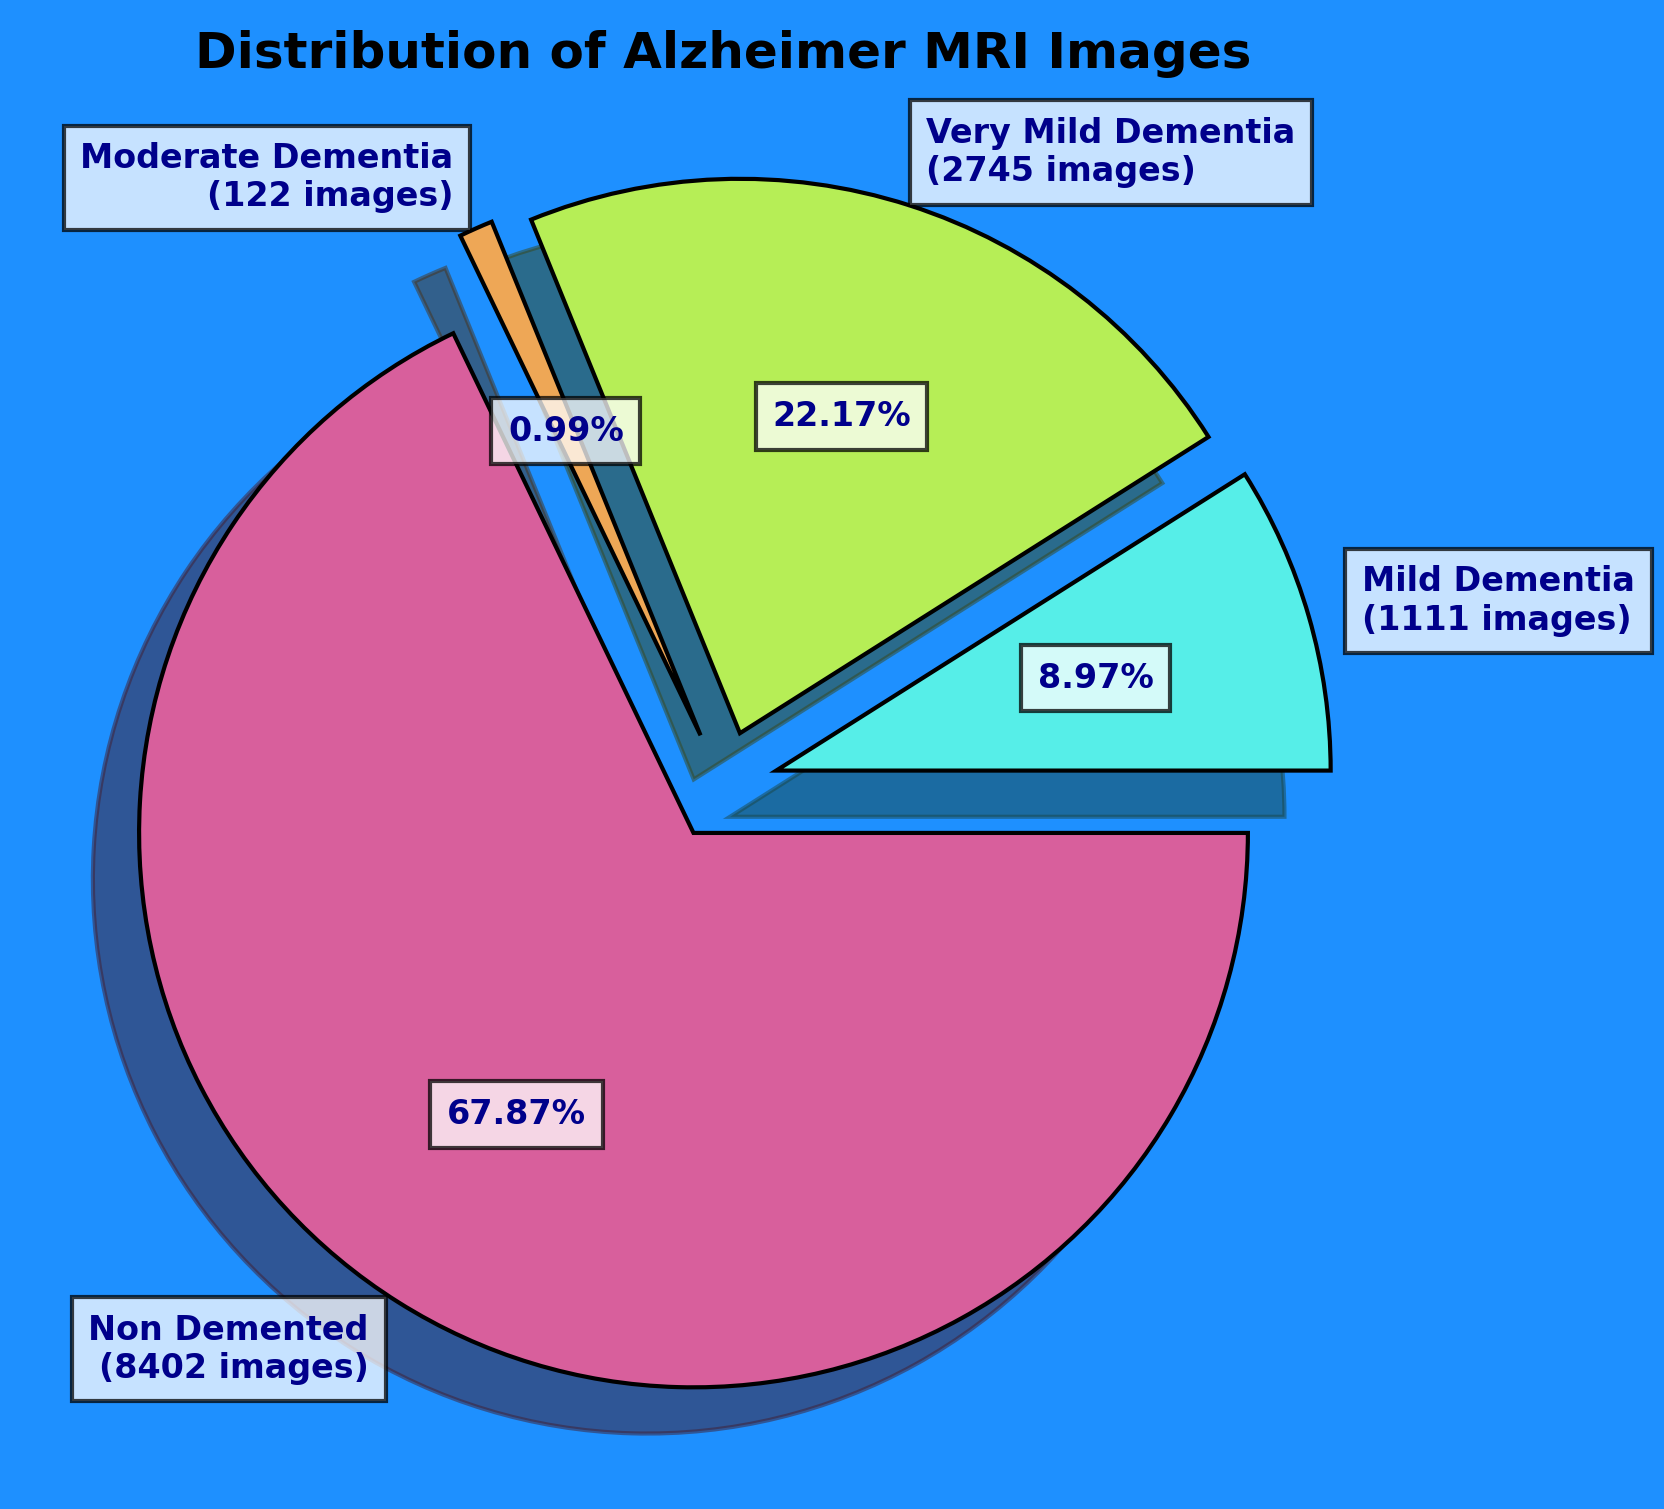

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#56EEE8", "#B6EE56", "#EEA756", "#D85F9C"]

class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()
                if file_ext in image_extensions:
                    count += 1

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)

    #Pie Chart
    labels = [f'{key}\n({value} images)' for key, value in zip(keys, values)]
    fig = plt.figure()
    fig.patch.set_facecolor('dodgerblue')
    plt.pie(values, explode=explode,labels=labels, autopct='%1.2f%%',
            shadow=True, startangle=0, colors=colors,
            textprops = {'fontsize': 8, "fontweight" : "bold", "color":"darkblue",
            'bbox': dict(facecolor='white', alpha=0.75)},
            wedgeprops= {'edgecolor':'black'}, labeldistance=1.1)
    plt.title("Distribution of Alzheimer MRI Images", size=12, fontweight="bold", color="black")

PATH = '/content/drive/MyDrive/Dataset For Alzheimer/New data'
image_counter(PATH)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Dapat diperhatikan dataset yang tersedia merupakan imbalanced dataset. <b>Non Demented MRI class terdiri dari 67.87% dengan total 8402 citra</b>, Sedangkan <b>Moderate Demented MRI class hanya memiliki 0.99% dari total seluruh dataset dengan 122 citra.</b></p>

# Generate TF Dataset

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(64, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 12380 files belonging to 4 classes.


<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">MRI Samples for Each Class</h2>

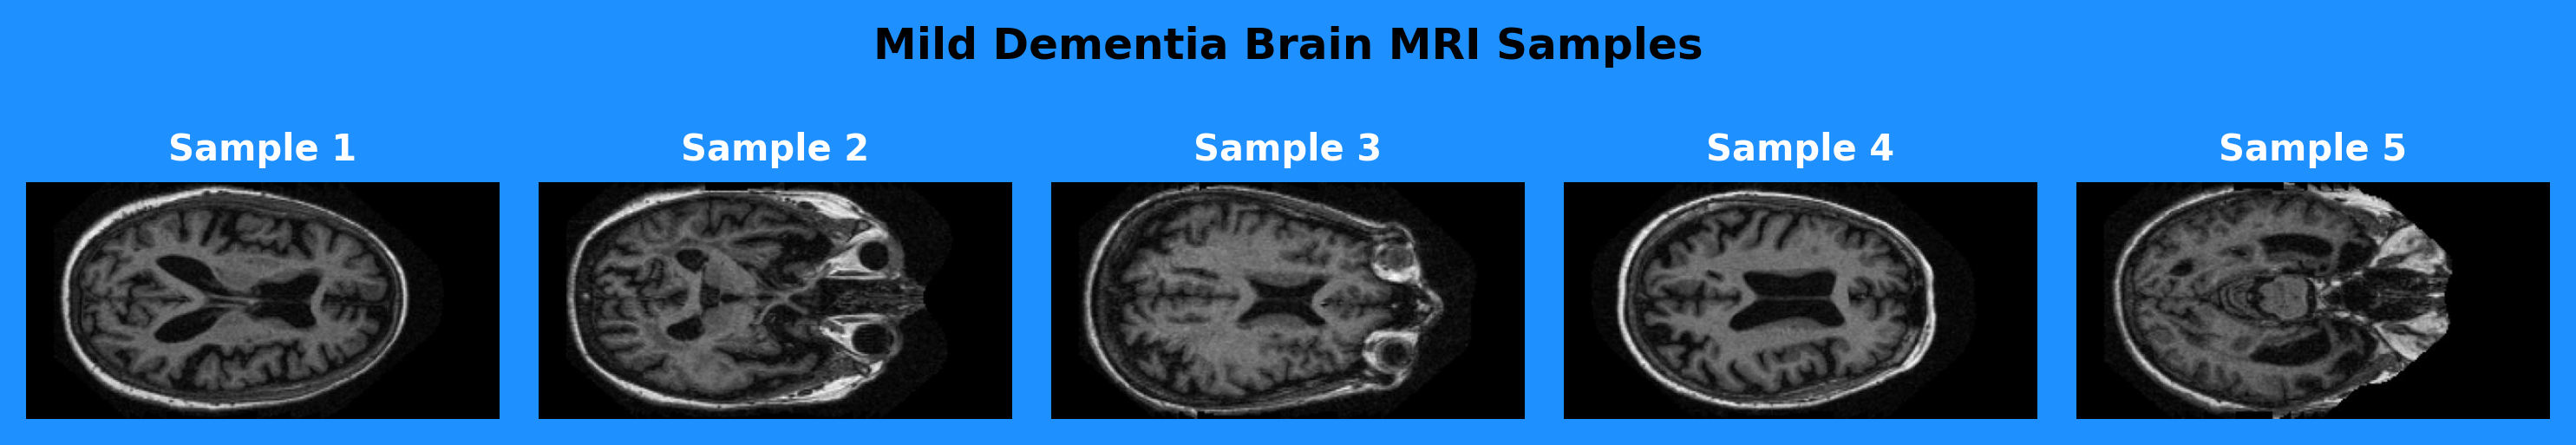

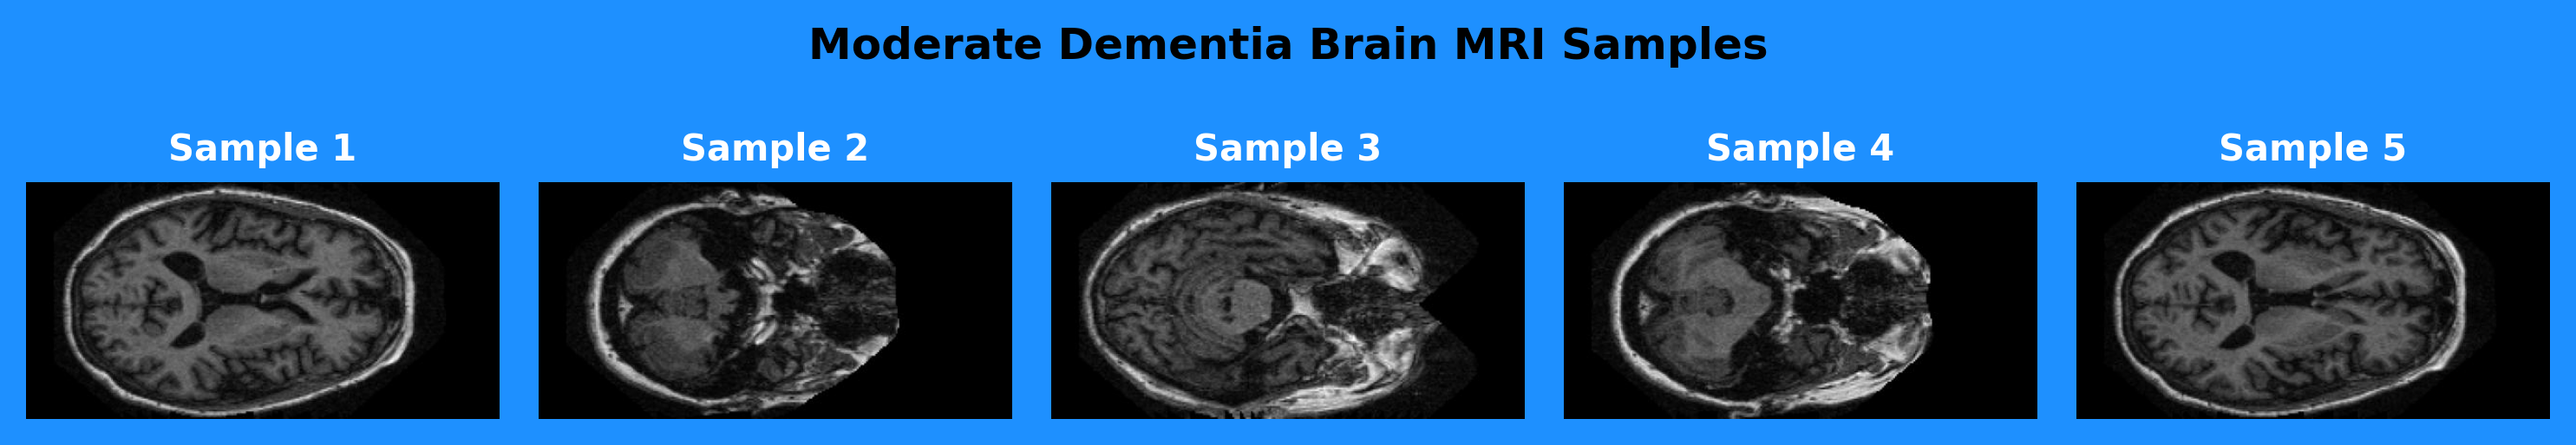

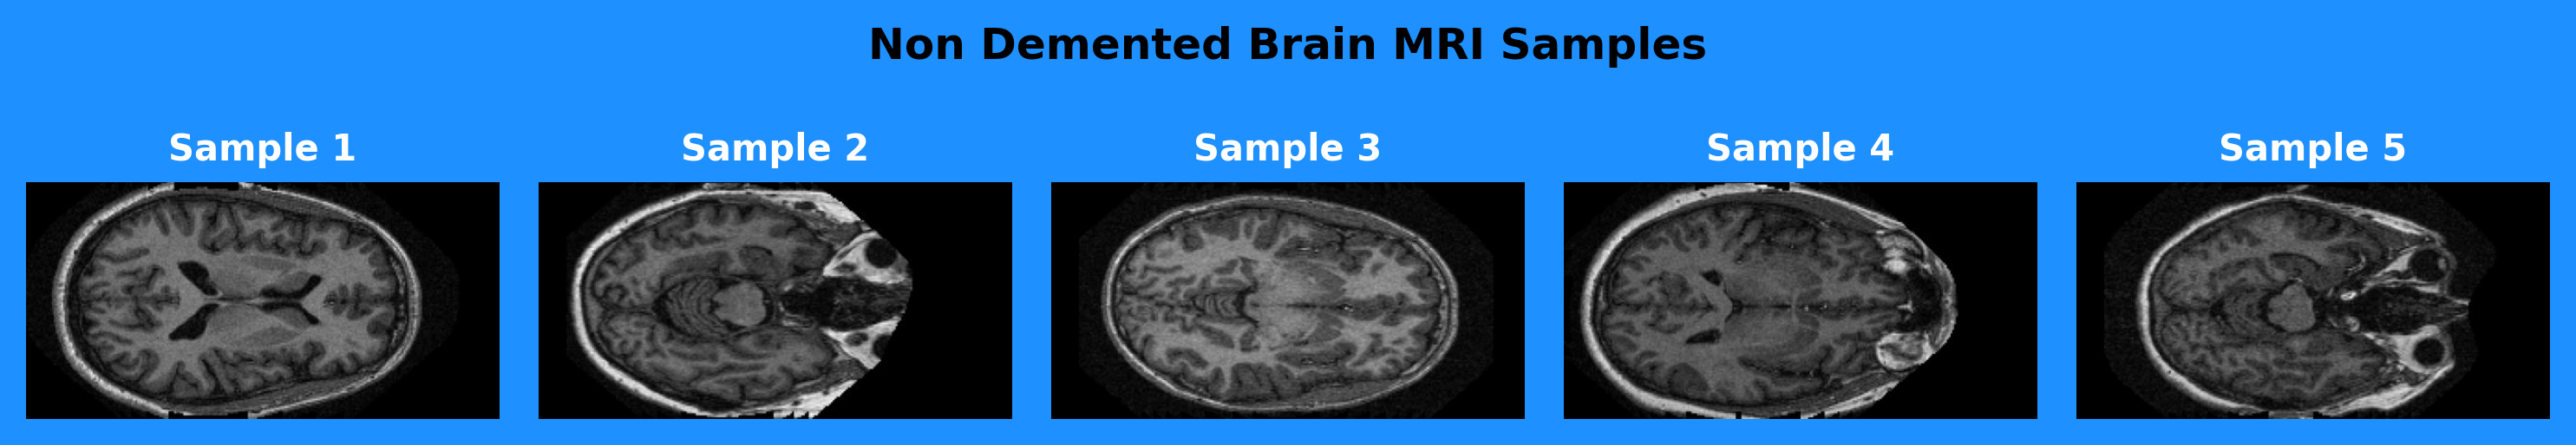

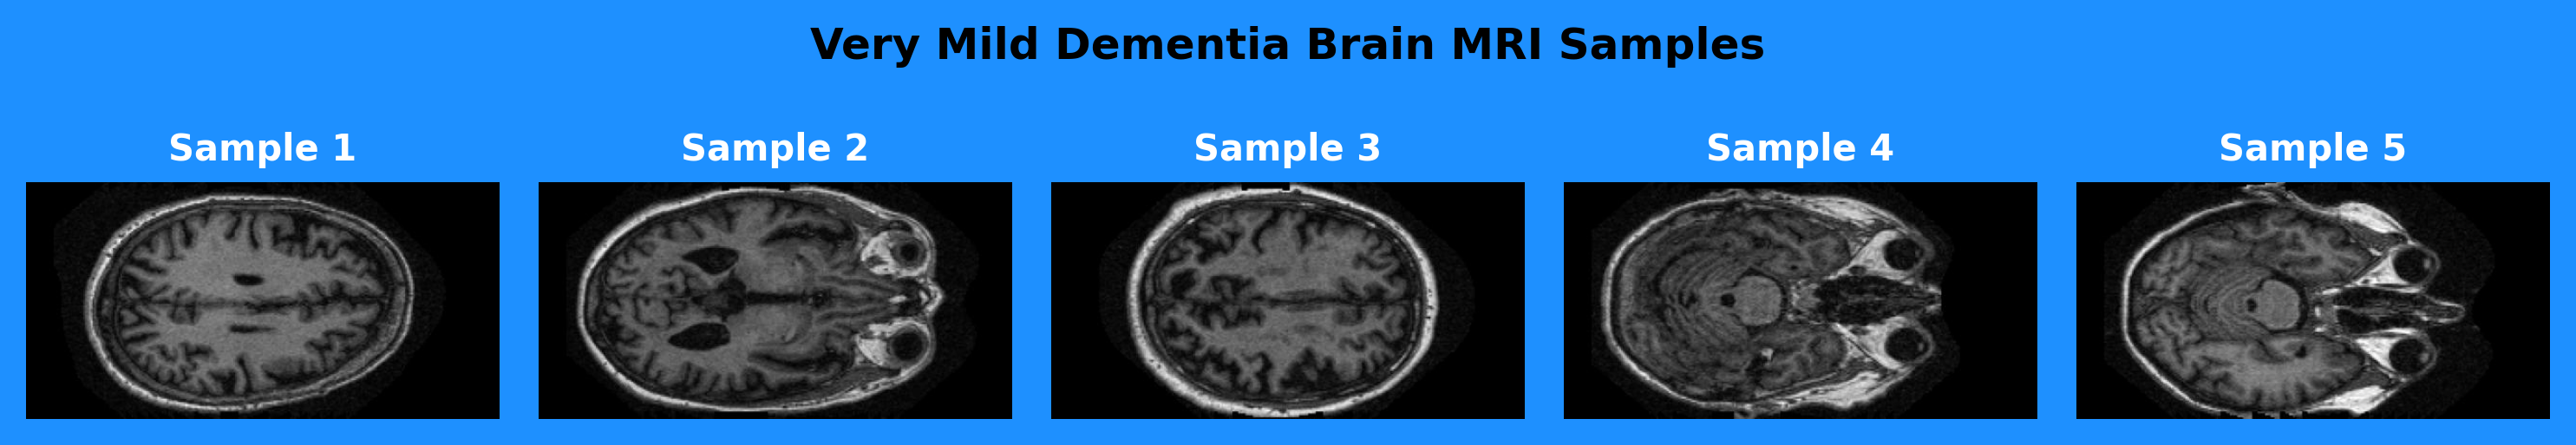

In [ ]:
def sample_bringer(path, target, num_samples=5):

    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="dodgerblue")
    fig.suptitle(f'{target} Brain MRI Samples', color="black",fontsize=12, fontweight='bold', y=0.65)

    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="white", fontsize=10, fontweight='bold')

    plt.tight_layout()

for target in class_names:
    sample_bringer(PATH, target=target)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;"> Lakukan normalisasi piksel dengan tujuan untuk meningkatkan kinerja dari Convolutional Neural Network. Oleh karena itu, kita akan mengubah nilai rentang piksel pada citra dataset yang semula bernilai antara 0 hingga 255 diubah ke nilai antara 0 hingga 1.</p>

In [ ]:
import matplotlib.pyplot as plt

alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="dodgerblue")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="black", fontsize=18, fontweight='bold', y=0.57)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="white", fontsize=12, fontweight='bold')
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_val_split(self, train_size, val_size):
        # Assuming data is a tf.data.Dataset object
        data_size = len(list(self.data.as_numpy_iterator()))
        train = int(data_size * train_size)
        val = int(data_size * val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)

        return train_data, val_data

Min and max pixel values in the batch -> 0.0 & 0.98276657


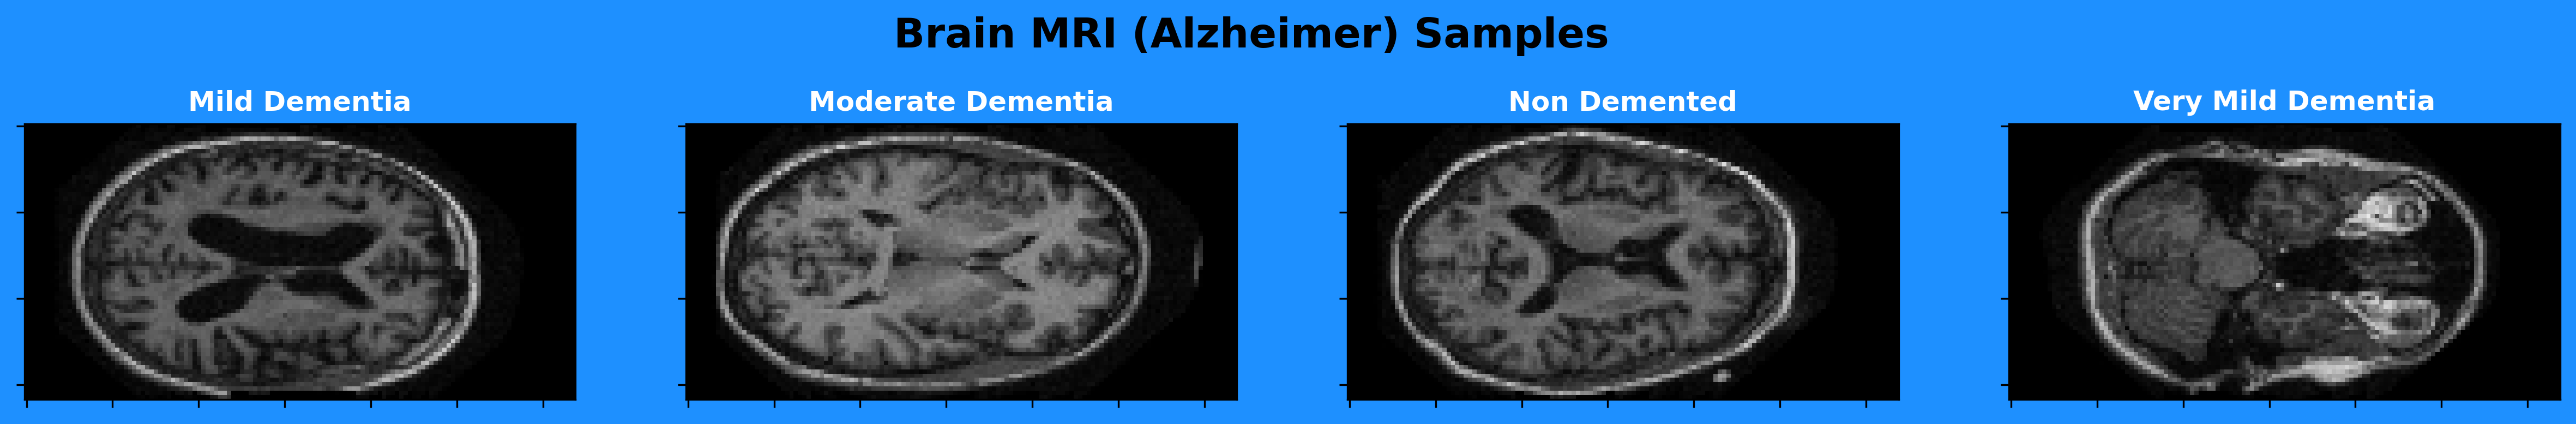

In [ ]:
process = Process(data)
process.create_new_batch()

process.show_batch_images(number_of_images=4)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Bagi dataset ke dalam data pelatihan (training data) sebesar 80% dan data validasi (validation data) sebesar 20%.</p>

In [ ]:
train_data, val_data = process.train_val_split(train_size=0.8, val_size=0.2)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">
Dataset mempunyai distribusi kelas yang tidak seimbang. Untuk menghadapi distribusi kelas yang tidak seimbang, dapat dilakukan dengan menggunakan class weight yang bertujuan untuk meningkatkan performa model lebih baik dan mengenali kelas minoritas secara efektif.</p>

In [ ]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

# Model Building

In [ ]:
from tensorflow import keras
from keras import layers
from tensorflow.keras import Sequential
from keras.layers import Dropout

# Define the model architecture
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),
                 activation="relu", kernel_initializer='he_normal',
                 input_shape=(64, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
                activation="relu", kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                 activation="relu", kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))  # Assuming 4 classes

# Compile the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

# Display the model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 28, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 14, 128)      

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Specify a valid directory for saving checkpoints
def checkpoint_callback():
    checkpoint_filepath = '/path/to/save/checkpoints'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

checkpoint_callback = checkpoint_callback()
callbacks = [checkpoint_callback]

In [ ]:
# Use the checkpoint in your model.fit using class_weight
history2 = model.fit(train_data, epochs = 20, validation_data = val_data,
                    class_weight = class_weights, callbacks = callbacks)

Epoch 1/20




309/309 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.4481
Epoch 1: val_accuracy improved from -inf to 0.59578, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 39s 116ms/step - loss: 1.0967 - accuracy: 0.4481 - val_loss: 0.8869 - val_accuracy: 0.5958
Epoch 2/20
309/309 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.7507
Epoch 2: val_accuracy improved from 0.59578 to 0.80925, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 35s 113ms/step - loss: 0.4590 - accuracy: 0.7507 - val_loss: 0.4660 - val_accuracy: 0.8093
Epoch 3/20
309/309 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.8776
Epoch 3: val_accuracy improved from 0.80925 to 0.90341, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 34s 110ms/step - loss: 0.2014 - accuracy: 0.8776 - val_loss: 0.2557 - val_accuracy: 0.9034
Epoch 4/20
309/309 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9324
Epoch 4: val_accuracy did not improve from 0.90341
309/309 [==============================] - 31s 100ms/step - loss: 0.1040 - accuracy: 0.9324 - val_loss: 0.2962 - val_accuracy: 0.8799
Epoch 5/20
309/309 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9665
Epoch 5: val_accuracy improved from 0.90341 to 0.92492, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 32s 103ms/step - loss: 0.0528 - accuracy: 0.9665 - val_loss: 0.1934 - val_accuracy: 0.9249
Epoch 6/20
309/309 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9685
Epoch 6: val_accuracy improved from 0.92492 to 0.92614, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 35s 112ms/step - loss: 0.0584 - accuracy: 0.9685 - val_loss: 0.2083 - val_accuracy: 0.9261
Epoch 7/20
309/309 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9820
Epoch 7: val_accuracy improved from 0.92614 to 0.93709, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 33s 107ms/step - loss: 0.0321 - accuracy: 0.9820 - val_loss: 0.2071 - val_accuracy: 0.9371
Epoch 8/20
309/309 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9803
Epoch 8: val_accuracy did not improve from 0.93709
309/309 [==============================] - 35s 114ms/step - loss: 0.0296 - accuracy: 0.9803 - val_loss: 0.1898 - val_accuracy: 0.9355
Epoch 9/20
309/309 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9906
Epoch 9: val_accuracy improved from 0.93709 to 0.95414, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 42s 135ms/step - loss: 0.0154 - accuracy: 0.9906 - val_loss: 0.1366 - val_accuracy: 0.9541
Epoch 10/20
309/309 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.9473
Epoch 10: val_accuracy did not improve from 0.95414
309/309 [==============================] - 37s 118ms/step - loss: 0.1206 - accuracy: 0.9473 - val_loss: 0.8595 - val_accuracy: 0.6380
Epoch 11/20
309/309 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9377
Epoch 11: val_accuracy improved from 0.95414 to 0.97200, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 35s 114ms/step - loss: 0.1252 - accuracy: 0.9377 - val_loss: 0.0848 - val_accuracy: 0.9720
Epoch 12/20
309/309 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9925
Epoch 12: val_accuracy improved from 0.97200 to 0.97890, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 32s 104ms/step - loss: 0.0145 - accuracy: 0.9925 - val_loss: 0.0623 - val_accuracy: 0.9789
Epoch 13/20
308/309 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9967
Epoch 13: val_accuracy improved from 0.97890 to 0.98255, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 32s 104ms/step - loss: 0.0060 - accuracy: 0.9967 - val_loss: 0.0522 - val_accuracy: 0.9825
Epoch 14/20
309/309 [==============================] - ETA: 0s - loss: 7.6830e-04 - accuracy: 1.0000
Epoch 14: val_accuracy improved from 0.98255 to 0.98498, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 33s 106ms/step - loss: 7.6830e-04 - accuracy: 1.0000 - val_loss: 0.0472 - val_accuracy: 0.9850
Epoch 15/20
309/309 [==============================] - ETA: 0s - loss: 2.5957e-04 - accuracy: 1.0000
Epoch 15: val_accuracy improved from 0.98498 to 0.98620, saving model to /path/to/save\checkpoints
INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


INFO:tensorflow:Assets written to: /path/to/save\checkpoints\assets


309/309 [==============================] - 33s 105ms/step - loss: 2.5957e-04 - accuracy: 1.0000 - val_loss: 0.0468 - val_accuracy: 0.9862
Epoch 16/20
309/309 [==============================] - ETA: 0s - loss: 1.5804e-04 - accuracy: 1.0000
Epoch 16: val_accuracy did not improve from 0.98620
309/309 [==============================] - 32s 102ms/step - loss: 1.5804e-04 - accuracy: 1.0000 - val_loss: 0.0470 - val_accuracy: 0.9858
Epoch 17/20
309/309 [==============================] - ETA: 0s - loss: 1.1109e-04 - accuracy: 1.0000
Epoch 17: val_accuracy did not improve from 0.98620
309/309 [==============================] - 32s 104ms/step - loss: 1.1109e-04 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 0.9862
Epoch 18/20
309/309 [==============================] - ETA: 0s - loss: 8.2320e-05 - accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 0.98620
309/309 [==============================] - 33s 107ms/step - loss: 8.2320e-05 - accuracy: 1.0000 - val_loss: 0.0475 - val_accura

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Loss and Accuracy</h2>

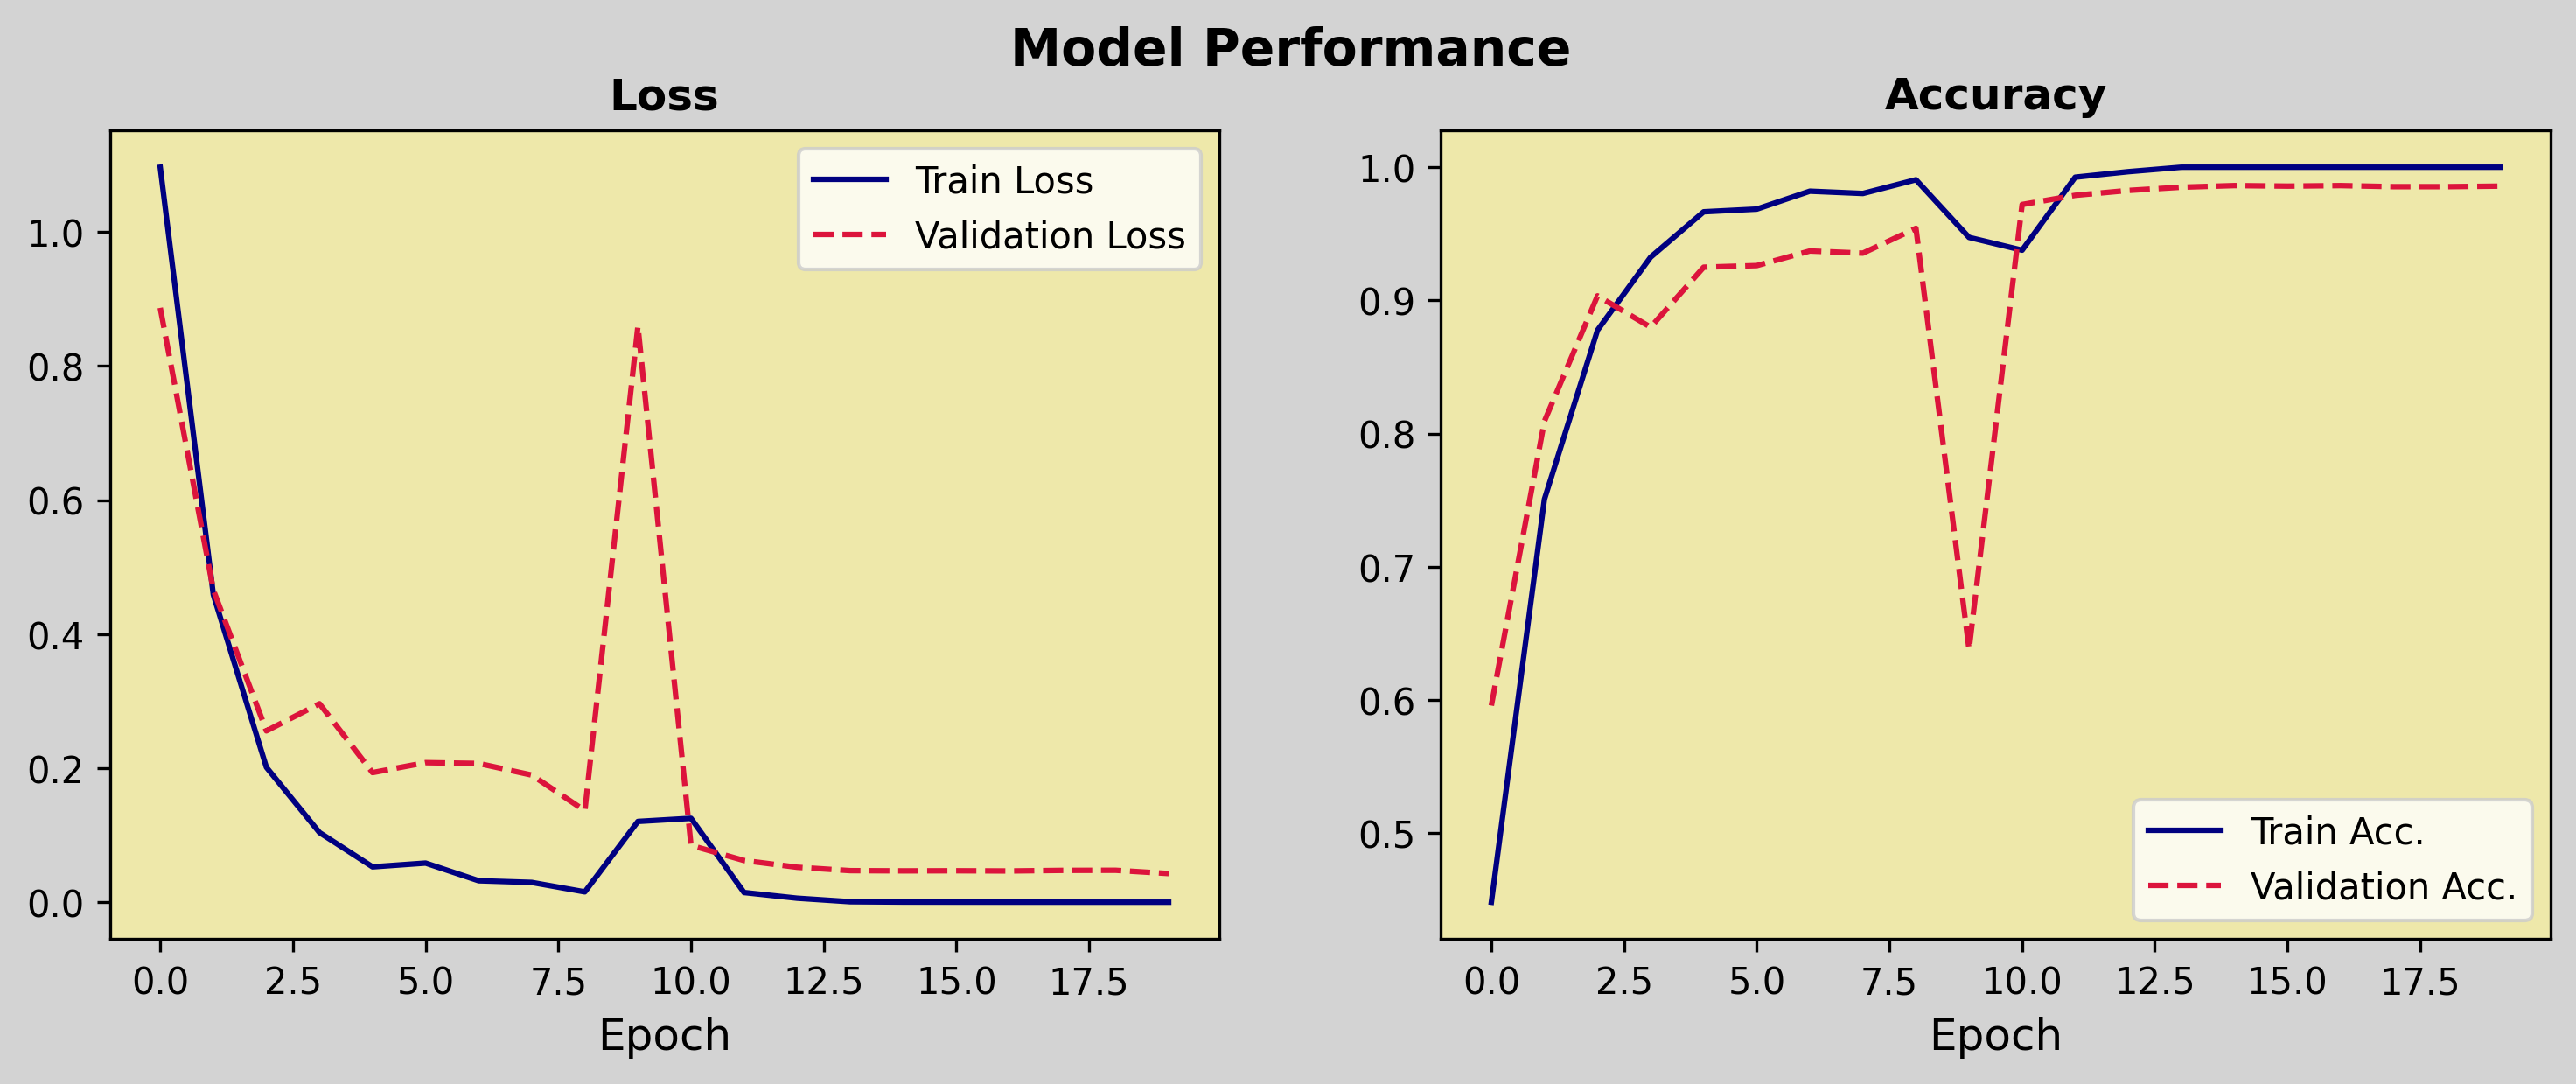

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), facecolor="lightgrey")
fig.suptitle("Model Performance", fontsize=14, fontweight="bold")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=12)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss",
           color="crimson", linestyle="dashed")
ax[0].legend()

ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=12)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.",
           color="crimson", linestyle="dashed")
ax[1].legend()

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Testing Random Images</h2>

In [ ]:
import os
import random

def select_random_file(folder_path):
    files = os.listdir(folder_path)
    selected_file = random.choice(files)
    print(f"File yang dipilih secara acak: {selected_file}")

    return os.path.join(folder_path, selected_file)

folder_path = '/content/drive/MyDrive/Dataset For Alzheimer/Test data (1=N,2=VM,3=M,4=Mo)'
selected_file_path = select_random_file(folder_path)

if selected_file_path:
    os.system(f"start {selected_file_path}")

File yang dipilih secara acak: OAS1_0001_MR1_mpr-4_10_7.jpg


1/1 [==============================] - 0s 40ms/step
Predicted class: Moderate Dementia


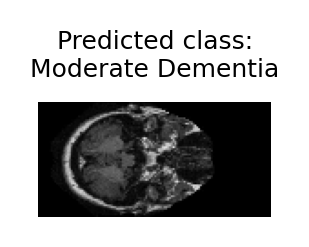

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Path to the sample image
img_path = selected_file_path
# Convert the image to grayscale and save it
img = Image.open(img_path).convert('LA')
img.save('greyscale.png')

# Assuming model_input_shape is the expected input shape of your model
model_input_shape = (64, 128, 3)

# Predicting images
img = image.load_img('greyscale.png', target_size=(model_input_shape[0], model_input_shape[1]))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Resize the input images to match the expected input shape
x = tf.image.resize(x, (model_input_shape[0], model_input_shape[1]))
images = np.vstack([x])

# Predicting probabilities for each class
probabilities = model.predict(images, batch_size=10)

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(probabilities)
predicted_class = class_names[predicted_class_index]

print(f'Predicted class: {predicted_class}')
# Set the figure size to reduce the image output size
plt.figure(figsize=(1, 1/2))
plt.axis('off')
plt.title(f'Predicted class:\n{predicted_class}', fontsize=6)
plt.imshow(img, aspect='auto')
plt.show()

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">
Dapat dilihat pada pengujian, bahwa dengan menggunakan Class Weight, Model dapat memprediksi secara tepat dan akurat, baik pada kelas citra Moderate Dementia yang merupakan kelas minoritas.</p>